# MNIST by ZIP

**tl;dr: We can use compression algorithms (like the well-known zip file compression) for machine learning purposes, specifically for classifying hand-written digits (MNIST). Code available: [https://github.com/BlackHC/mnist_by_zip](https://github.com/BlackHC/mnist_by_zip).**

## Acknowledgements

Thanks to Christopher Mattern (from DeepMind) for mentioning this to me a couple of years ago at Friday Drinks and to [Owen Campbell Moore](https://twitter.com/owencm) for turning a random afternoon conversation into a tiny hack project later. I have always remembered it as a fun fact and was surprised when no one else knew about it either. So, here we go. :)

In [15]:
import numpy as np
from torchvision import datasets

In [16]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels

from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt

from sklearn import metrics

import zlib
import tqdm

In [17]:
test_dataset = datasets.MNIST('.', train=False, download=True)
train_dataset = datasets.MNIST('.', train=True, download=True)

train_data = train_dataset.data.reshape(-1, 28*28)
test_data = test_dataset.data.reshape(-1, 28*28)

train_targets = train_dataset.targets
test_targets = test_dataset.targets

0it [00:00, ?it/s]

9920512it [00:03, 3168364.51it/s]                             


Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 117227.42it/s]           
0it [00:00, ?it/s]

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:01, 1597430.35it/s]                            
0it [00:00, ?it/s]

Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 45112.89it/s]            

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [18]:
class ZipCompressionClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, **params):
        self.params_ = params

    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        num_classes = len(self.classes_)
        
        X_by_class = [X[y == c] for c in self.classes_]
        
        # Create the compression objects.
        compress_obj_by_class = [zlib.compressobj(**self.params_) for _ in range(num_classes)]
        for compress_obj, class_X in tqdm.tqdm_notebook(zip(compress_obj_by_class, X_by_class), total=num_classes):
            compress_obj.compress(class_X.tobytes())          
        
        # We need to do a bit of house keeping as have to determine how many bytes are unflushed.        
        flush_lengths = [
            len(compress_obj.copy().flush())
            for compress_obj in compress_obj_by_class]
        
        self.compress_obj_by_class_ = compress_obj_by_class
        self.flush_lengths_ = flush_lengths
  
        # Return the classifier
        return self

    def predict(self, X):
        # Check is fit had been called
        check_is_fitted(self, ['compress_obj_by_class_', 'flush_lengths_', 'classes_'])

        # Input validation
        X = check_array(X)        
        
        y = []
        
        # For each sample x in the batch...
        for x in tqdm.tqdm_notebook(X):
          # Append the data to each compression object and measure how many extra bytes we need.
          compressed_delta_by_class = []
          for compress_obj, original_flush_length in zip(self.compress_obj_by_class_, self.flush_lengths_):
            compress_obj = compress_obj.copy()
            length = len(compress_obj.compress(x.tobytes()))            
            length += len(compress_obj.flush())         
            compressed_delta_by_class.append(length - original_flush_length)
           
          compressed_delta_by_class = np.asarray(compressed_delta_by_class)          
          best_compressed_index = np.argmin(compressed_delta_by_class)
          y.append(self.classes_[best_compressed_index])
        
        return np.asarray(y)


In [19]:
#@title plot_confusion_matrix definition from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html {display-mode: "form"}

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


In [20]:
def train_and_evaluate_MNSIT(classifier, train_data, train_targets, test_data, test_targets, class_names):
  class_names = np.asarray(class_names)
  print('Training')
  classifier.fit(train_data, train_targets)
  
  # Now predict the value of the digit on the second half:
  expected = test_targets
  
  print('Predicting')
  predicted = classifier.predict(test_data)

  print("Classification report for classifier %s:\n%s\n"
        % (classifier, metrics.classification_report(expected, predicted)))
 
  # Plot non-normalized confusion matrix
  plot_confusion_matrix(expected, predicted, classes=class_names,
                      title='Confusion matrix, without normalization')
  
  plt.show()

  # Plot normalized confusion matrix
  plot_confusion_matrix(expected, predicted, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

  plt.show()

## All defaults

Training



Predicting



Classification report for classifier ZipCompressionClassifier():
              precision    recall  f1-score   support

           0       0.61      0.09      0.15       980
           1       0.50      0.87      0.63      1135
           2       0.19      0.23      0.21      1032
           3       0.14      0.22      0.17      1010
           4       0.16      0.18      0.17       982
           5       0.16      0.22      0.18       892
           6       0.36      0.12      0.17       958
           7       0.27      0.18      0.22      1028
           8       0.41      0.24      0.31       974
           9       0.23      0.24      0.24      1009

   micro avg       0.27      0.27      0.27     10000
   macro avg       0.30      0.26      0.24     10000
weighted avg       0.30      0.27      0.25     10000


Confusion matrix, without normalization
[[ 85   3 269 221  93 149  21  48  55  36]
 [  1 982   5  22  39  22   4  42   2  16]
 [ 14  72 237 242 124 118  32  74  46  73]
 [ 10

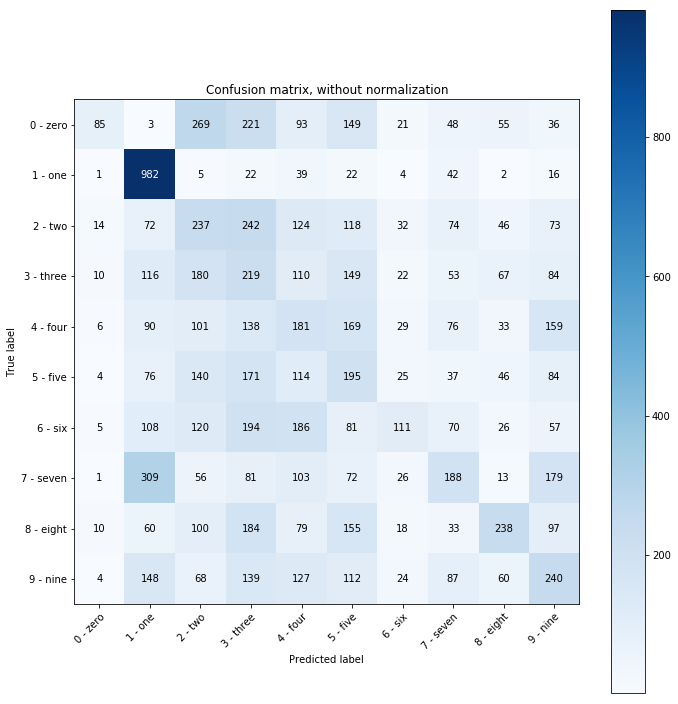

Normalized confusion matrix
[[0.08673469 0.00306122 0.2744898  0.2255102  0.09489796 0.15204082
  0.02142857 0.04897959 0.05612245 0.03673469]
 [0.00088106 0.86519824 0.00440529 0.01938326 0.03436123 0.01938326
  0.00352423 0.03700441 0.00176211 0.01409692]
 [0.01356589 0.06976744 0.22965116 0.23449612 0.12015504 0.11434109
  0.03100775 0.07170543 0.04457364 0.07073643]
 [0.00990099 0.11485149 0.17821782 0.21683168 0.10891089 0.14752475
  0.02178218 0.05247525 0.06633663 0.08316832]
 [0.00610998 0.09164969 0.10285132 0.14052953 0.18431772 0.17209776
  0.02953157 0.07739308 0.03360489 0.16191446]
 [0.0044843  0.08520179 0.15695067 0.19170404 0.12780269 0.21860987
  0.02802691 0.04147982 0.05156951 0.0941704 ]
 [0.00521921 0.11273486 0.12526096 0.20250522 0.19415449 0.08455115
  0.11586639 0.07306889 0.02713987 0.05949896]
 [0.00097276 0.30058366 0.05447471 0.07879377 0.10019455 0.07003891
  0.02529183 0.18287938 0.01264591 0.17412451]
 [0.01026694 0.06160164 0.1026694  0.1889117  0.0811

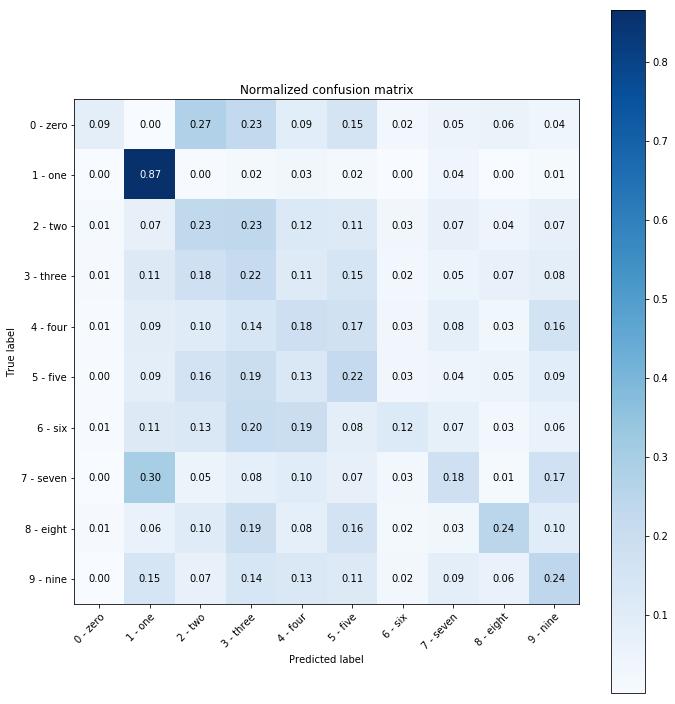

In [21]:
train_and_evaluate_MNSIT(ZipCompressionClassifier(), train_data, train_targets, test_data, test_targets, train_dataset.classes)

## Compression level 9 and wbits=-10

Training



Predicting



Classification report for classifier ZipCompressionClassifier():
              precision    recall  f1-score   support

           0       0.58      0.28      0.37       980
           1       0.62      0.94      0.74      1135
           2       0.19      0.07      0.11      1032
           3       0.22      0.34      0.26      1010
           4       0.22      0.21      0.21       982
           5       0.20      0.17      0.18       892
           6       0.56      0.41      0.47       958
           7       0.23      0.32      0.27      1028
           8       0.36      0.33      0.35       974
           9       0.27      0.31      0.29      1009

   micro avg       0.35      0.35      0.35     10000
   macro avg       0.35      0.34      0.33     10000
weighted avg       0.35      0.35      0.33     10000


Confusion matrix, without normalization
[[ 272    1  122  204  141   56   34   35  102   13]
 [   0 1068    2    5    4    1    0   46    7    2]
 [  25   24   77  308  122  

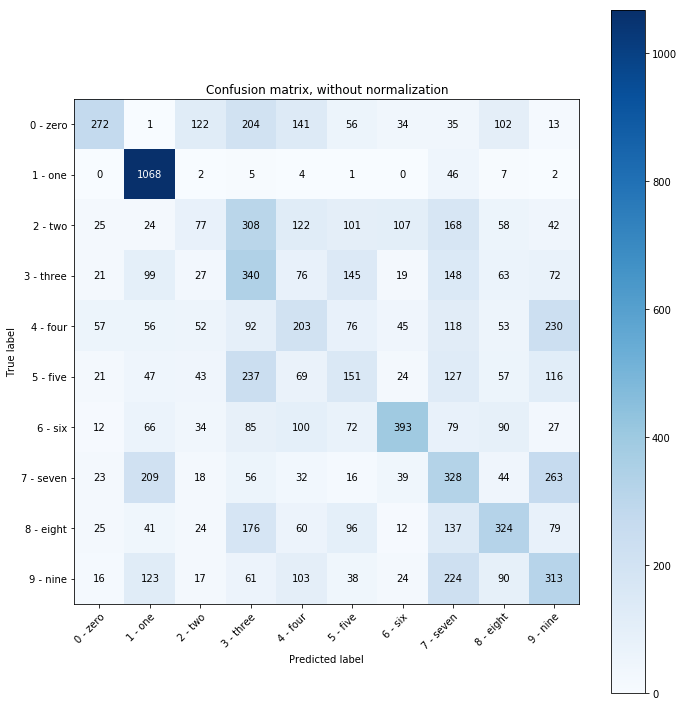

Normalized confusion matrix
[[2.77551020e-01 1.02040816e-03 1.24489796e-01 2.08163265e-01
  1.43877551e-01 5.71428571e-02 3.46938776e-02 3.57142857e-02
  1.04081633e-01 1.32653061e-02]
 [0.00000000e+00 9.40969163e-01 1.76211454e-03 4.40528634e-03
  3.52422907e-03 8.81057269e-04 0.00000000e+00 4.05286344e-02
  6.16740088e-03 1.76211454e-03]
 [2.42248062e-02 2.32558140e-02 7.46124031e-02 2.98449612e-01
  1.18217054e-01 9.78682171e-02 1.03682171e-01 1.62790698e-01
  5.62015504e-02 4.06976744e-02]
 [2.07920792e-02 9.80198020e-02 2.67326733e-02 3.36633663e-01
  7.52475248e-02 1.43564356e-01 1.88118812e-02 1.46534653e-01
  6.23762376e-02 7.12871287e-02]
 [5.80448065e-02 5.70264766e-02 5.29531568e-02 9.36863544e-02
  2.06720978e-01 7.73930754e-02 4.58248473e-02 1.20162933e-01
  5.39714868e-02 2.34215886e-01]
 [2.35426009e-02 5.26905830e-02 4.82062780e-02 2.65695067e-01
  7.73542601e-02 1.69282511e-01 2.69058296e-02 1.42376682e-01
  6.39013453e-02 1.30044843e-01]
 [1.25260960e-02 6.88935282e-0

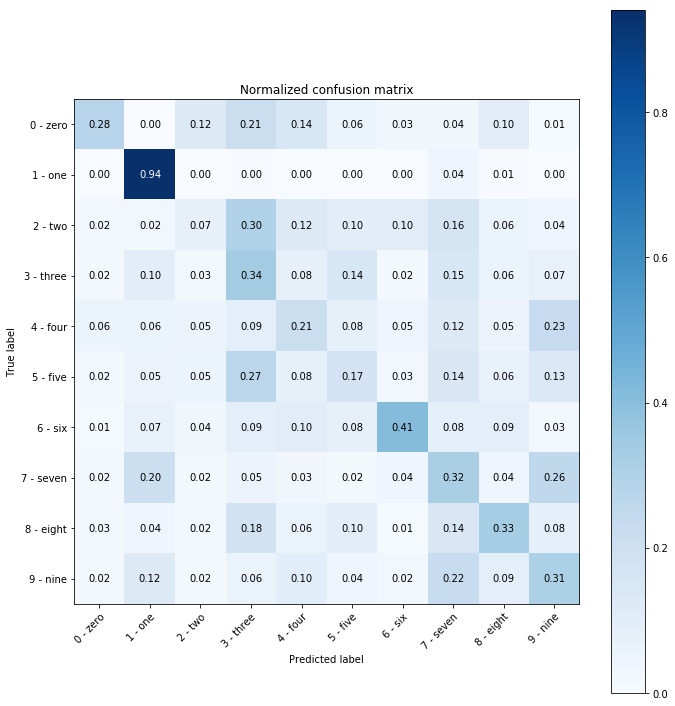

In [22]:
train_and_evaluate_MNSIT(ZipCompressionClassifier(level=9, wbits=-10), train_data, train_targets, test_data, test_targets, train_dataset.classes)

## Thresholding at 128, and compression level=9, and wbits=-9

Training



Predicting



Classification report for classifier ZipCompressionClassifier():
              precision    recall  f1-score   support

           0       0.38      0.71      0.50       980
           1       0.95      0.70      0.80      1135
           2       0.29      0.44      0.35      1032
           3       0.37      0.32      0.34      1010
           4       0.49      0.39      0.43       982
           5       0.29      0.33      0.31       892
           6       0.68      0.33      0.44       958
           7       0.47      0.46      0.46      1028
           8       0.51      0.57      0.54       974
           9       0.42      0.24      0.30      1009

   micro avg       0.45      0.45      0.45     10000
   macro avg       0.49      0.45      0.45     10000
weighted avg       0.49      0.45      0.45     10000


Confusion matrix, without normalization
[[699   0  50  27   3  30  11  21 132   7]
 [ 28 792  17  13  58  51   3 137   4  32]
 [142   1 457  83  17 106  32 100  66  28]
 [151

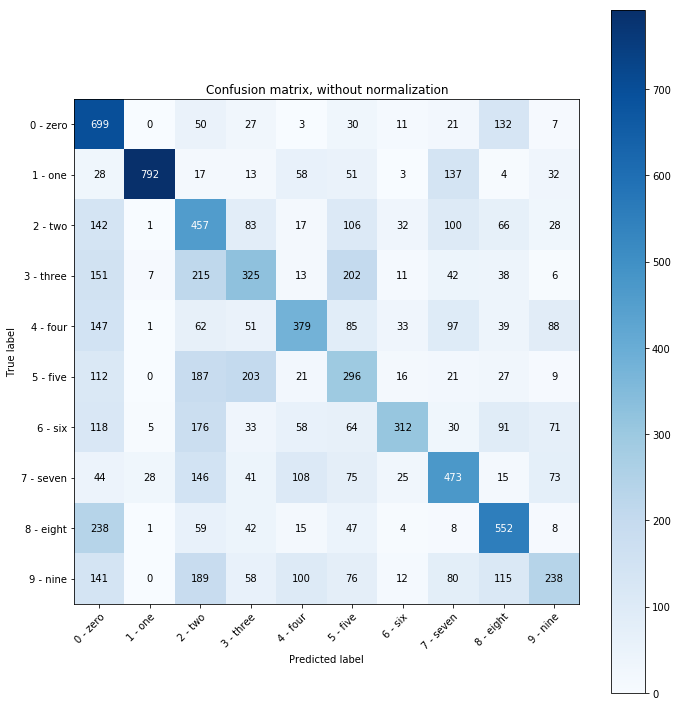

Normalized confusion matrix
[[0.71326531 0.         0.05102041 0.02755102 0.00306122 0.03061224
  0.01122449 0.02142857 0.13469388 0.00714286]
 [0.0246696  0.69779736 0.01497797 0.01145374 0.05110132 0.04493392
  0.00264317 0.12070485 0.00352423 0.02819383]
 [0.1375969  0.00096899 0.44282946 0.08042636 0.01647287 0.10271318
  0.03100775 0.09689922 0.06395349 0.02713178]
 [0.14950495 0.00693069 0.21287129 0.32178218 0.01287129 0.2
  0.01089109 0.04158416 0.03762376 0.00594059]
 [0.1496945  0.00101833 0.06313646 0.05193483 0.38594705 0.08655804
  0.03360489 0.098778   0.03971487 0.08961303]
 [0.12556054 0.         0.20964126 0.22757848 0.0235426  0.33183857
  0.01793722 0.0235426  0.03026906 0.01008969]
 [0.12317328 0.00521921 0.18371608 0.03444676 0.0605428  0.06680585
  0.3256785  0.03131524 0.09498956 0.07411273]
 [0.04280156 0.02723735 0.14202335 0.03988327 0.10505837 0.0729572
  0.02431907 0.46011673 0.01459144 0.07101167]
 [0.24435318 0.00102669 0.06057495 0.04312115 0.01540041 0.0

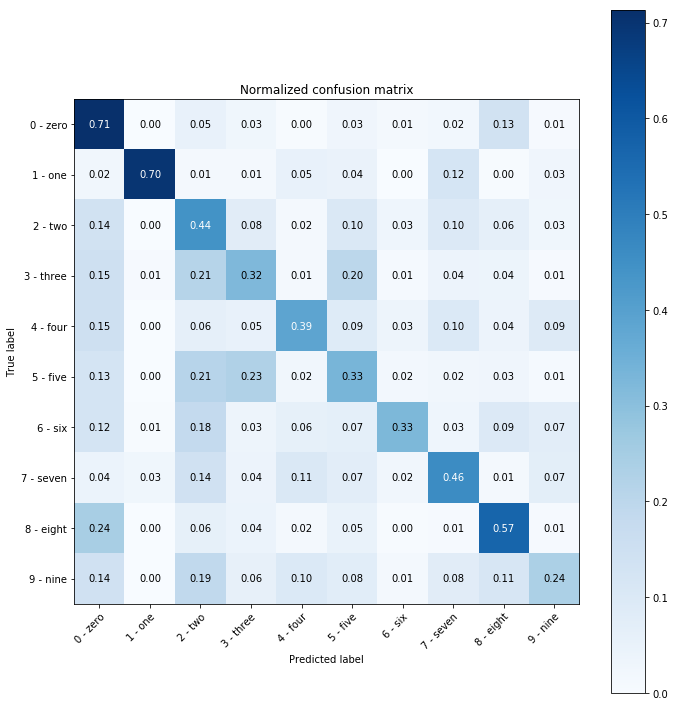

In [23]:
train_and_evaluate_MNSIT(ZipCompressionClassifier(level=9), train_data >= 128, train_targets, test_data >= 128, test_targets, train_dataset.classes)

Training



Predicting



Classification report for classifier ZipCompressionClassifier():
              precision    recall  f1-score   support

           0       0.42      0.70      0.52       980
           1       0.95      0.47      0.63      1135
           2       0.25      0.18      0.21      1032
           3       0.30      0.26      0.28      1010
           4       0.34      0.32      0.33       982
           5       0.26      0.38      0.31       892
           6       0.30      0.39      0.34       958
           7       0.37      0.42      0.39      1028
           8       0.48      0.34      0.40       974
           9       0.27      0.22      0.24      1009

   micro avg       0.37      0.37      0.37     10000
   macro avg       0.39      0.37      0.37     10000
weighted avg       0.40      0.37      0.37     10000


Confusion matrix, without normalization
[[682   0  24  29  38  57  33   2  75  40]
 [ 10 537  15  17  64  28 121 280   2  61]
 [137   3 184 150  52 157 123 111  47  68]
 [116

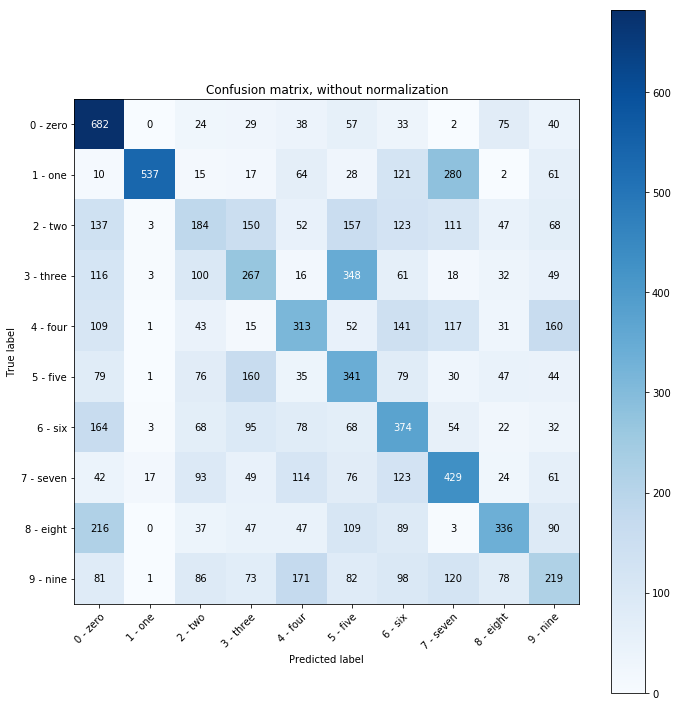

Normalized confusion matrix
[[0.69591837 0.         0.0244898  0.02959184 0.03877551 0.05816327
  0.03367347 0.00204082 0.07653061 0.04081633]
 [0.00881057 0.47312775 0.01321586 0.01497797 0.05638767 0.0246696
  0.10660793 0.24669604 0.00176211 0.05374449]
 [0.13275194 0.00290698 0.17829457 0.14534884 0.0503876  0.15213178
  0.11918605 0.10755814 0.04554264 0.06589147]
 [0.11485149 0.0029703  0.0990099  0.26435644 0.01584158 0.34455446
  0.06039604 0.01782178 0.03168317 0.04851485]
 [0.11099796 0.00101833 0.04378819 0.01527495 0.31873727 0.05295316
  0.14358452 0.1191446  0.03156823 0.16293279]
 [0.08856502 0.00112108 0.08520179 0.1793722  0.03923767 0.382287
  0.08856502 0.03363229 0.05269058 0.04932735]
 [0.17118998 0.00313152 0.07098121 0.09916493 0.08141962 0.07098121
  0.39039666 0.05636743 0.02296451 0.03340292]
 [0.04085603 0.01653696 0.09046693 0.04766537 0.11089494 0.07392996
  0.11964981 0.41731518 0.0233463  0.05933852]
 [0.22176591 0.         0.03798768 0.04825462 0.0482546

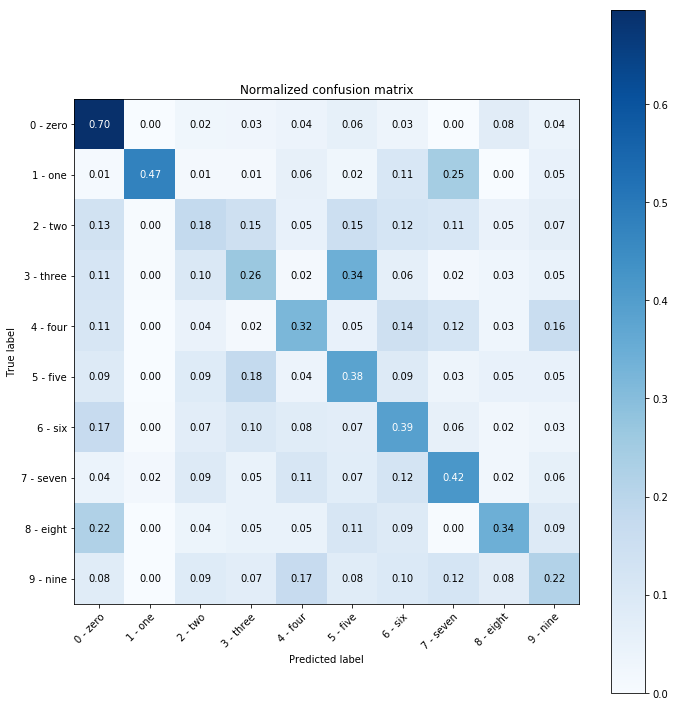

In [24]:
train_and_evaluate_MNSIT(ZipCompressionClassifier(level=9), (train_data >= 128)[::200], train_targets[::200], test_data >= 128, test_targets, train_dataset.classes)

# MNIST by counting pixels + nearest neighbor

Training
Predicting
Classification report for classifier KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=20, p=2,
           weights='distance'):
              precision    recall  f1-score   support

           0       0.23      0.45      0.30       980
           1       0.49      0.69      0.57      1135
           2       0.12      0.16      0.13      1032
           3       0.12      0.13      0.13      1010
           4       0.12      0.16      0.14       982
           5       0.09      0.05      0.06       892
           6       0.10      0.07      0.08       958
           7       0.15      0.09      0.11      1028
           8       0.15      0.05      0.07       974
           9       0.15      0.09      0.11      1009

   micro avg       0.20      0.20      0.20     10000
   macro avg       0.17      0.19      0.17     10000
weighted avg       0.18      0.20      0.18     10000


Confusion mat

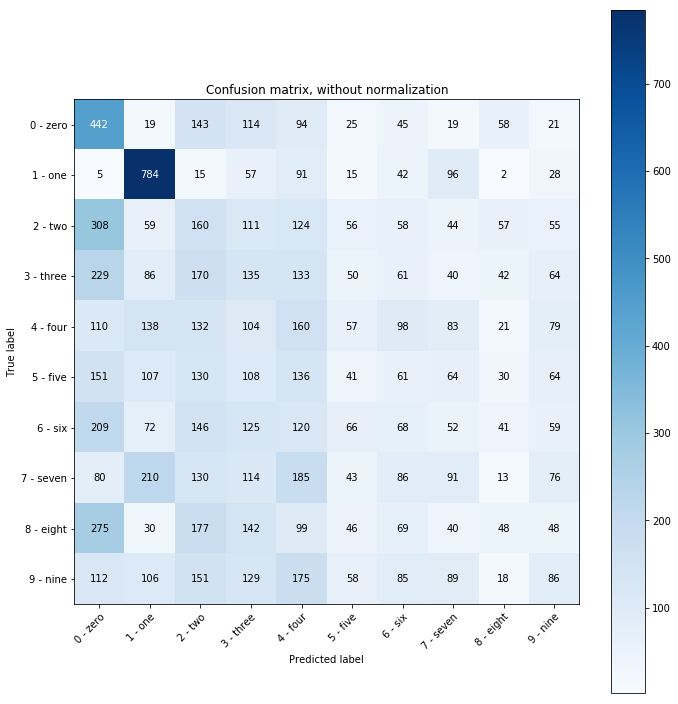

Normalized confusion matrix
[[0.45102041 0.01938776 0.14591837 0.11632653 0.09591837 0.0255102
  0.04591837 0.01938776 0.05918367 0.02142857]
 [0.00440529 0.6907489  0.01321586 0.05022026 0.08017621 0.01321586
  0.03700441 0.0845815  0.00176211 0.0246696 ]
 [0.29844961 0.05717054 0.15503876 0.10755814 0.12015504 0.05426357
  0.05620155 0.04263566 0.05523256 0.05329457]
 [0.22673267 0.08514851 0.16831683 0.13366337 0.13168317 0.04950495
  0.06039604 0.03960396 0.04158416 0.06336634]
 [0.11201629 0.14052953 0.13441955 0.10590631 0.16293279 0.05804481
  0.09979633 0.08452138 0.02138493 0.08044807]
 [0.16928251 0.11995516 0.14573991 0.12107623 0.15246637 0.04596413
  0.06838565 0.07174888 0.03363229 0.07174888]
 [0.21816284 0.07515658 0.15240084 0.13048017 0.12526096 0.06889353
  0.07098121 0.05427975 0.04279749 0.06158664]
 [0.07782101 0.20428016 0.12645914 0.11089494 0.17996109 0.04182879
  0.08365759 0.0885214  0.01264591 0.07392996]
 [0.28234086 0.03080082 0.18172485 0.14579055 0.10164

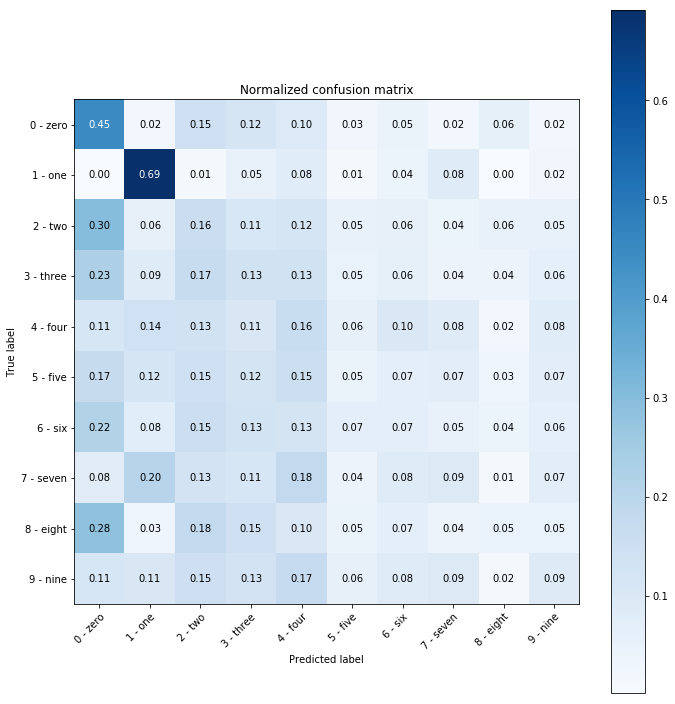

In [25]:
train_and_evaluate_MNSIT(KNeighborsClassifier(20, weights='distance'), np.count_nonzero(train_data >= 128, axis=1).reshape(-1, 1), train_targets, np.count_nonzero(test_data >= 128, axis=1).reshape(-1, 1), test_targets, train_dataset.classes)

## Create text-based training files

In [26]:
import os

In [27]:
os.makedirs('data', exist_ok=True)

def array2string(data):
  return np.array2string(data.numpy(), threshold=28*28*60000, max_line_width=4*28+20)
  
 
for y in tqdm.tqdm_notebook(train_dataset.class_to_idx.values()):
  train_name = f'data/digit_{y}.train'
  with open(train_name, 'wb') as train_file:
    train_file.write(train_data[train_targets == y].numpy().tobytes())

In [28]:
for i in range(10):
  test_name = f'data/test{i}_{test_targets[i]}.image'
  with open(test_name, 'wb') as test_file:
    test_file.write(test_data[i].numpy().tobytes())

In [29]:
!ls -lh data/

total 45M
-rw-rw-r-- 1 blackhc blackhc 4.5M Jul 16 16:36 digit_0.train
-rw-rw-r-- 1 blackhc blackhc 5.1M Jul 16 16:36 digit_1.train
-rw-rw-r-- 1 blackhc blackhc 4.5M Jul 16 16:36 digit_2.train
-rw-rw-r-- 1 blackhc blackhc 4.6M Jul 16 16:36 digit_3.train
-rw-rw-r-- 1 blackhc blackhc 4.4M Jul 16 16:36 digit_4.train
-rw-rw-r-- 1 blackhc blackhc 4.1M Jul 16 16:36 digit_5.train
-rw-rw-r-- 1 blackhc blackhc 4.5M Jul 16 16:36 digit_6.train
-rw-rw-r-- 1 blackhc blackhc 4.7M Jul 16 16:36 digit_7.train
-rw-rw-r-- 1 blackhc blackhc 4.4M Jul 16 16:36 digit_8.train
-rw-rw-r-- 1 blackhc blackhc 4.5M Jul 16 16:36 digit_9.train
-rw-rw-r-- 1 blackhc blackhc  784 Jul 16 16:36 test0_7.image
-rw-rw-r-- 1 blackhc blackhc  784 Jul 16 16:36 test1_2.image
-rw-rw-r-- 1 blackhc blackhc  784 Jul 16 16:36 test2_1.image
-rw-rw-r-- 1 blackhc blackhc  784 Jul 16 16:36 test3_0.image
-rw-rw-r-- 1 blackhc blackhc  784 Jul 16 16:36 test4_4.image
-rw-rw-r-- 1 blackhc blackhc  784 Jul 16 16:36 test5_1.image
-rw-rw-r-- 1 b